In [1]:
# Imports
import os
import itertools
import logging
import zipfile
import pandas as pd
import sklearn as sk
import numpy as np
import torch
import shapely
import matplotlib.pyplot as plt
import laspy # Reading LAS file format
from tqdm import tqdm # Loading bars
import geopandas as gpd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [2]:
# Configurations
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s - %(levelname)s - %(message)s",
    handlers=[
        logging.StreamHandler()  # Direct logs to the notebook's output
    ]
)

GLOBAL_MIN_X, GLOBAL_MAX_X = 6374000, 6641000
GLOBAL_MIN_Y, GLOBAL_MAX_Y = 364000, 742000
GLOBAL_MIN_Z, GLOBAL_MAX_Z = -125, 320 # Munamägi

In [3]:
# Rasterize a shapely polygon for overlay
def rasterize_polygon(polygon, x_min, x_max, y_min, y_max, resolution):
    """
    Converts a polygon into a binary mask over a 2D grid.

    Parameters:
        polygon (shapely.Polygon): Polygon to rasterize.
        x_min, x_max, y_min, y_max (float): Bounding box of the grid.
        resolution (int): Resolution of the grid (number of rows/columns).

    Returns:
        np.ndarray: 2D binary mask (1 inside the polygon, 0 outside).
    """
    # Initialize an empty grid
    grid = np.zeros((resolution, resolution), dtype=np.uint8)
    
    # Create evenly spaced coordinates within the bounding box
    x_range = np.linspace(x_min, x_max, resolution)
    y_range = np.linspace(y_min, y_max, resolution)
    
    # Iterate through each grid cell and check if it is within the polygon
    for i, y in enumerate(y_range):
        for j, x in enumerate(x_range):
            if polygon.contains(shapely.Point(x, y)):  # Check if the grid point is inside the polygon
                grid[i, j] = 1  # Mark the grid cell as inside the polygon
    return grid

In [4]:
# Function to blend mask into an image with transparency
def apply_transparency(image, mask, mask_color, alpha):
    """
    Applies a semi-transparent mask overlay to an image.

    Parameters:
        image (np.ndarray): Original RGB image (H x W x 3).
        mask (np.ndarray): Binary mask (H x W) where 1 indicates the mask region.
        mask_color (list): RGB color for the mask (e.g., [255, 0, 0] for red).
        alpha (float): Transparency level (0 to 1, where 1 is fully opaque).

    Returns:
        np.ndarray: RGB image with the mask applied.
    """
    # Create a copy of the original image to avoid overwriting
    blended_image = image.copy()
    
    # Get indices where the mask is active
    mask_indices = mask == 1  # Binary mask where 1 indicates the mask area
    
    # Blend mask color with the original image in the masked region
    for channel in range(3):  # Loop over RGB channels
        blended_image[..., channel][mask_indices] = (
            (1 - alpha) * blended_image[..., channel][mask_indices] + alpha * mask_color[channel]
        )
    
    return blended_image

In [5]:
def generate_color_image(laz_files, resolution=512, additional_features=[]):
    """
    Generates a color image from multiple LAZ files.

    Parameters:
        laz_files (list): List of LAZ objects containing point cloud data.
        resolution (int): Resolution for the output grid.
        additional_features (list): List of additional features to include (e.g., 'z', 'classification').

    Returns:
        tuple: (color_image, additional_feature_maps)
            - color_image: 3D numpy array (H x W x 3) for RGB.
            - additional_feature_maps: Dictionary of feature maps for additional features.
    """
    # Initialize color image
    color_image = np.zeros((resolution, resolution, 3), dtype=np.uint8)

    # Additional feature maps
    feature_maps = {feature: np.zeros((resolution, resolution)) for feature in additional_features}

    for las in laz_files:
        # Extract X, Y, RGB
        x, y = las.x, las.y
        red, green, blue = las.red, las.green, las.blue

        # Extract additional features
        features = {feature: getattr(las, feature) for feature in additional_features}

        # Normalize X, Y to fit into a 2D grid
        x_min, x_max = np.min(las.header.x_min), np.max(las.header.x_max)
        y_min, y_max = np.min(las.header.y_min), np.max(las.header.y_max)

        x_norm = ((x - x_min) / (x_max - x_min)) * (resolution - 1)
        y_norm = ((y - y_min) / (y_max - y_min)) * (resolution - 1)

        # Convert to integers for indexing
        x_indices = np.clip(x_norm.astype(np.int32), 0, resolution - 1)
        y_indices = np.clip(y_norm.astype(np.int32), 0, resolution - 1)

        # Flatten indices
        flat_indices = y_indices * resolution + x_indices
        unique_indices, inverse_indices = np.unique(flat_indices, return_inverse=True)

        # Aggregate RGB values
        red_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
        green_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
        blue_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)

        np.add.at(red_aggregated, inverse_indices, red / 65535 * 255)
        np.add.at(green_aggregated, inverse_indices, green / 65535 * 255)
        np.add.at(blue_aggregated, inverse_indices, blue / 65535 * 255)

        # Assign to color image
        color_image.flat[unique_indices * 3] = (red_aggregated / np.bincount(inverse_indices)).astype(np.uint8)
        color_image.flat[unique_indices * 3 + 1] = (green_aggregated / np.bincount(inverse_indices)).astype(np.uint8)
        color_image.flat[unique_indices * 3 + 2] = (blue_aggregated / np.bincount(inverse_indices)).astype(np.uint8)

        # Aggregate and assign additional features
        for feature, feature_map in feature_maps.items():
            feature_aggregated = np.zeros(unique_indices.shape, dtype=np.float32)
            np.add.at(feature_aggregated, inverse_indices, features[feature])
            feature_map.flat[unique_indices] = feature_aggregated / np.bincount(inverse_indices)

    return color_image, feature_maps

In [6]:
def plot_color_images(color_image, masked_color_image, title1='Original Colorized Image', title2='Masked Colorized Image'):
    """
    Plots the color image and masked color image side by side.

    Parameters:
        color_image (numpy.ndarray): Original color image (H x W x 3).
        masked_color_image (numpy.ndarray): Masked color image (H x W x 3).
        title1 (str): Title for the first subplot.
        title2 (str): Title for the second subplot.
    """
    fig, axs = plt.subplots(1, 2, figsize=(24, 18))

    # Original Colorized Image
    axs[0].imshow(np.flip(color_image, axis=0))
    axs[0].set_title(title1)
    axs[0].axis('off')

    # Masked Colorized Image
    axs[1].imshow(np.flip(masked_color_image, axis=0))
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.show()

In [33]:
# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [34]:
def denormalize_points(df):
    result_df = df.copy(deep=True)
    result_df['x'] = df['x'] * (GLOBAL_MAX_Y - GLOBAL_MIN_Y) + GLOBAL_MIN_Y
    result_df['y'] = df['y'] * (GLOBAL_MAX_X - GLOBAL_MIN_X) + GLOBAL_MIN_X
    result_df['z'] = df['z'] * (GLOBAL_MAX_Z - GLOBAL_MIN_Z) + GLOBAL_MIN_Z
    return result_df

In [7]:
downsampled_data = pd.read_parquet('../data/downsampled_points.parquet')
test_results = pd.read_parquet('../data/test_results.parquet')

In [9]:
display(downsampled_data)
display(test_results)

,x,y,z,r,g,b,file
0,0.860079,0.086190,0.72822,113.556420,135.470817,93.634241,397689_2023_tava.laz
1,0.860008,0.086186,0.72834,51.797665,51.797665,41.836576,397689_2023_tava.laz
2,0.860058,0.086156,0.72818,101.603113,110.568093,83.673152,397689_2023_tava.laz
3,0.860076,0.086193,0.75631,105.587549,105.587549,85.665370,397689_2023_tava.laz
4,0.860079,0.086156,0.72807,85.665370,68.731518,71.719844,397689_2023_tava.laz
...,...,...,...,...,...,...,...
9818758,0.729969,0.850155,0.29744,67.735409,80.684825,63.750973,600639_2022_tava.laz
9818759,0.729992,0.850108,0.32090,152.404669,149.416342,118.536965,600639_2022_tava.laz
9818760,0.729972,0.850107,0.31263,95.626459,93.634241,72.715953,600639_2022_tava.laz
9818761,0.729904,0.850165,0.29798,87.657588,87.657588,75.704280,600639_2022_tava.laz


,x,y,z,true_label,pred_label
0,0.105841,0.430748,0.34670,0,0
1,0.105859,0.430747,0.32993,0,0
2,0.105888,0.430789,0.36971,0,0
3,0.105859,0.430728,0.33126,0,0
4,0.105850,0.430762,0.37328,0,0
...,...,...,...,...,...
1945988,0.335903,0.498102,0.30126,0,0
1945989,0.335928,0.498104,0.30070,0,0
1945990,0.335921,0.498125,0.30058,0,0
1945991,0.335949,0.498113,0.30038,0,1


In [10]:
downsampled_df = denormalize_points(downsampled_data)
test_results_df = denormalize_points(test_results)
display(downsampled_df)
display(test_results_df)

,x,y,z,r,g,b,file
0,689109.77884,6.397013e+06,199.05790,113.556420,135.470817,93.634241,397689_2023_tava.laz
1,689083.20922,6.397012e+06,199.11130,51.797665,51.797665,41.836576,397689_2023_tava.laz
2,689101.88998,6.397004e+06,199.04010,101.603113,110.568093,83.673152,397689_2023_tava.laz
3,689108.67886,6.397014e+06,211.55795,105.587549,105.587549,85.665370,397689_2023_tava.laz
4,689109.77884,6.397004e+06,198.99115,85.665370,68.731518,71.719844,397689_2023_tava.laz
...,...,...,...,...,...,...,...
9818758,639928.27066,6.600991e+06,7.36080,67.735409,80.684825,63.750973,600639_2022_tava.laz
9818759,639936.80968,6.600979e+06,17.80050,152.404669,149.416342,118.536965,600639_2022_tava.laz
9818760,639929.55964,6.600979e+06,14.12035,95.626459,93.634241,72.715953,600639_2022_tava.laz
9818761,639903.54946,6.600994e+06,7.60110,87.657588,87.657588,75.704280,600639_2022_tava.laz


,x,y,z,true_label,pred_label
0,404007.98872,6.489010e+06,29.28150,0,0
1,404014.83052,6.489009e+06,21.81885,0,0
2,404025.47878,6.489021e+06,39.52095,0,0
3,404014.67176,6.489004e+06,22.41070,0,0
4,404011.42096,6.489013e+06,41.10960,0,0
...,...,...,...,...,...
1945988,490971.28108,6.506993e+06,9.06070,0,0
1945989,490980.74998,6.506994e+06,8.81150,0,0
1945990,490978.24006,6.506999e+06,8.75810,0,0
1945991,490988.88076,6.506996e+06,8.66910,0,1


In [11]:
las_files = os.listdir('../data/downsampled_class_lazFiles')

In [12]:
# Filter points for a specific LAS file (example: '397689_2023_tava.laz')
selected_file = las_files[4]
filtered_df = downsampled_df[downsampled_df['file'] == selected_file]
display(filtered_df)

,x,y,z,r,g,b,file
331037,700000.24990,6.407000e+06,119.75000,56.778210,63.750973,57.774319,407700_2023_tava.laz
331038,700000.06846,6.407016e+06,120.39080,77.696498,85.665370,67.735409,407700_2023_tava.laz
331039,700003.25878,6.407003e+06,139.81950,70.723735,98.614786,63.750973,407700_2023_tava.laz
331040,700000.12894,6.407008e+06,131.55140,114.552529,138.459144,89.649805,407700_2023_tava.laz
331041,700002.29110,6.407021e+06,119.78115,74.708171,88.653696,54.785992,407700_2023_tava.laz
...,...,...,...,...,...,...,...
442523,700867.40836,6.407747e+06,114.11185,65.743191,91.642023,56.778210,407700_2023_tava.laz
442524,700850.14132,6.407744e+06,108.08210,38.848249,45.821012,51.797665,407700_2023_tava.laz
442525,700871.74024,6.407743e+06,133.93215,89.649805,131.486381,67.735409,407700_2023_tava.laz
442526,700848.51970,6.407738e+06,108.25120,51.797665,29.883268,43.828794,407700_2023_tava.laz


In [13]:
las_files = os.listdir('../data/downsampled_class_lazFiles')
merged_df = pd.DataFrame()
for las_name in las_files:
    selected_file = las_name
    filtered_df = downsampled_df[downsampled_df['file'] == selected_file]
    # Merge filtered points from 'filtered_df' and 'test_results_df' on 'x', 'y', 'z' coordinates
    merged_df = pd.merge(filtered_df[['x', 'y', 'z', 'r', 'g', 'b']], test_results_df[['x', 'y', 'z', 'true_label', 'pred_label']], 
                        on=['x', 'y', 'z'], how='inner')
    if merged_df.shape[0] > 1:
        print(f"Selected file: {selected_file}")
        break

Selected file: 407700_2023_tava.laz


In [14]:
display(merged_df)

,x,y,z,r,g,b,true_label,pred_label
0,700000.24990,6.407000e+06,119.75000,56.778210,63.750973,57.774319,0,0
1,700000.06846,6.407016e+06,120.39080,77.696498,85.665370,67.735409,0,0
2,700003.25878,6.407003e+06,139.81950,70.723735,98.614786,63.750973,0,0
3,700000.12894,6.407008e+06,131.55140,114.552529,138.459144,89.649805,0,0
4,700002.29110,6.407021e+06,119.78115,74.708171,88.653696,54.785992,0,0
...,...,...,...,...,...,...,...,...
111486,700867.40836,6.407747e+06,114.11185,65.743191,91.642023,56.778210,0,0
111487,700850.14132,6.407744e+06,108.08210,38.848249,45.821012,51.797665,0,0
111488,700871.74024,6.407743e+06,133.93215,89.649805,131.486381,67.735409,0,0
111489,700848.51970,6.407738e+06,108.25120,51.797665,29.883268,43.828794,0,0


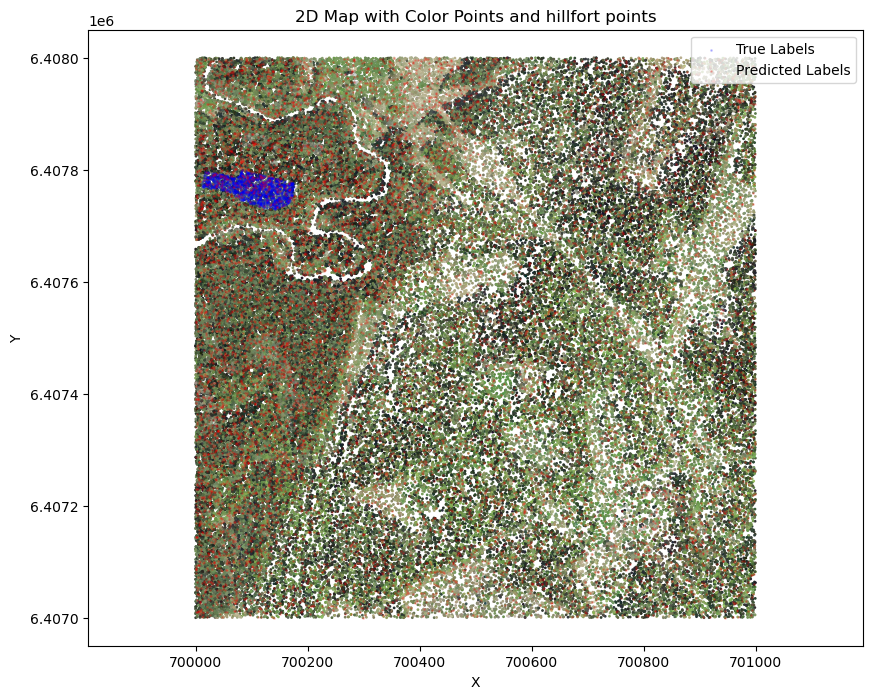

In [26]:
# Extract RGB values and coordinates (x, y)
x = merged_df['x']
y = merged_df['y']
r = merged_df['r']
g = merged_df['g']
b = merged_df['b']
# Filter points for true_labels (blue) and pred_labels (red)
true_label_points = merged_df[merged_df['true_label'] == 1]
pred_label_points = merged_df[merged_df['pred_label'] == 1]

# Create the RGB color map
colors = np.array([r, g, b]).T / 255  # Normalize RGB values to [0, 1]

# Create a scatter plot of the points colored by their RGB values
plt.figure(figsize=(10, 8))
plt.scatter(x, y, c=colors, s=1)  # s=1 to make the points small

# Scatter plot for true labels (blue)
plt.scatter(true_label_points['x'], true_label_points['y'], c='blue', s=1, alpha=0.2, label='True Labels')

# Scatter plot for predicted labels (red)
plt.scatter(pred_label_points['x'], pred_label_points['y'], c='red', s=1, alpha=0.2, label='Predicted Labels')

plt.legend(loc='upper right')
plt.title('2D Map with Color Points and hillfort points')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')  # Ensure equal scaling for X and Y axes
plt.show()

In [27]:
print(classification_report(merged_df['true_label'], merged_df['pred_label']))

              precision    recall  f1-score   support

           0       0.99      0.89      0.94    109830
           1       0.01      0.10      0.02      1661

    accuracy                           0.88    111491
   macro avg       0.50      0.50      0.48    111491
weighted avg       0.97      0.88      0.92    111491



In [28]:
cm = confusion_matrix(merged_df['true_label'], merged_df['pred_label']);
cm

array([[98201, 11629],
       [ 1495,   166]], dtype=int64)

A lot of Type I errors, which means that the model couldn't get the spatial context of the hillfort in the downsampled data.

Confusion matrixes

In [30]:
classes = {
    0: "Not Hillfort",
    1: "Hillfort"
}

Normalized confusion matrix


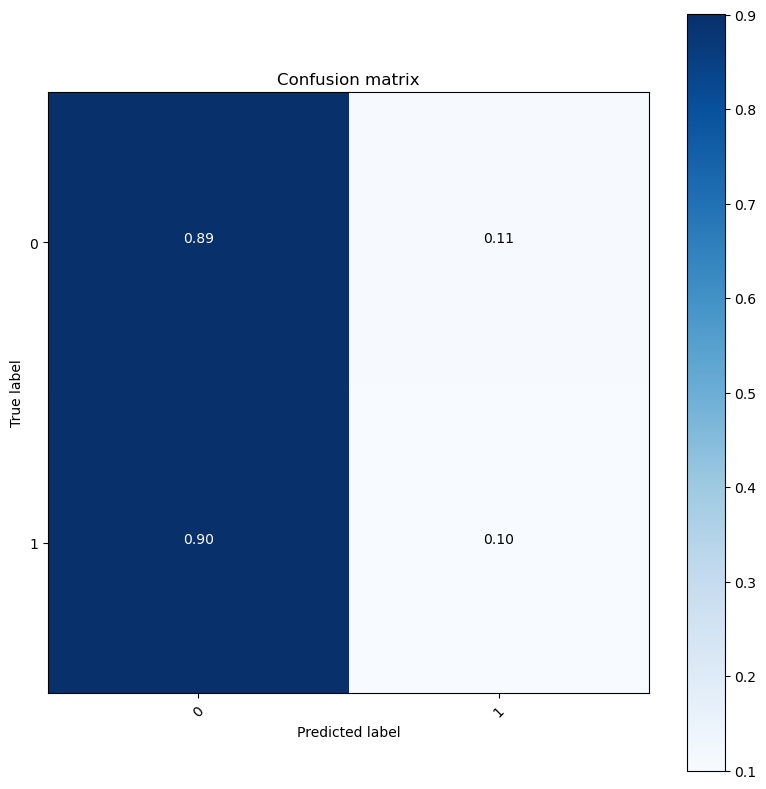

In [31]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=True)

Confusion matrix, without normalization


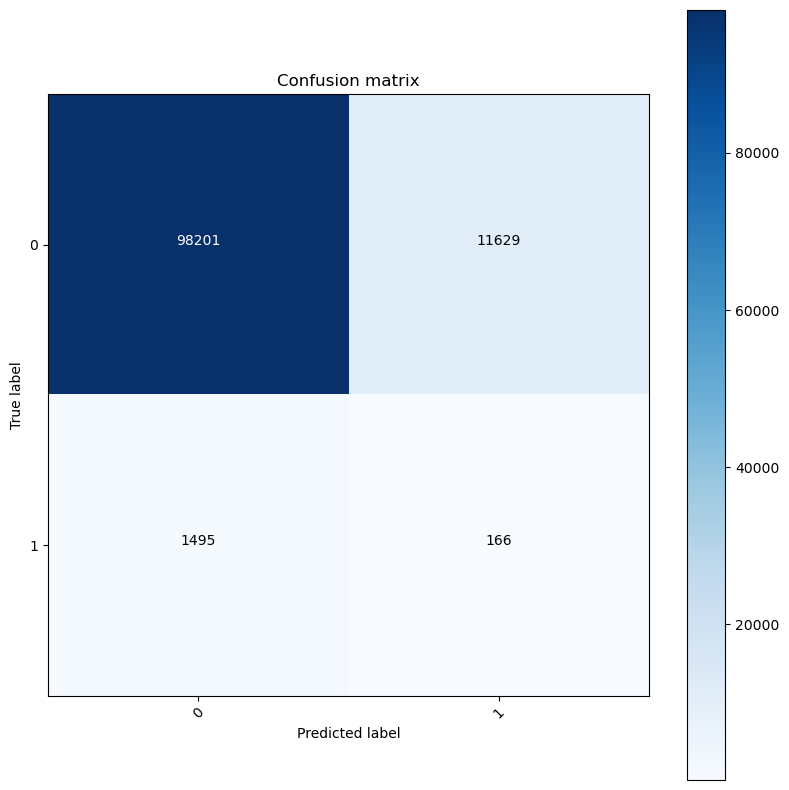

In [32]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes.keys()), normalize=False)